Tutorial: Raster-scan simulations - Thermoplasmonics
===============================
This is an example how to simulate raster-scans in pyGDM.

We start again by loading the pyGDM modules that we are going to use:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import nonlinear
from pyGDM2 import visu
from pyGDM2 import tools

Simulation setup
------------------

We'll use water as environment (n=1.33, kappa=0.6 W (m^-1 K^1) )

In [2]:
## --- Setup structure
step = 20.0
geometry = structures.rhombus(step, L=int(520/step), H=1, alpha=60, mesh='hex')
geometry = structures.center_struct(geometry)

material = materials.gold()
n1, n2 = 1.33, 1.33  # constant environment (water)

struct = structures.struct(step, geometry, material, n1,n2, 
                                   structures.get_normalization('hex'))

## --- Setup incident field
field_generator = fields.focused_planewave        # planwave excitation

## 50nm spotsize: LDOS; 200nm spotsize: TPL map
kwargs = dict(theta = [0, 90], spotsize=[200], kSign=-1, 
              xSpot=np.linspace(-500, 500, 25), 
              ySpot=np.linspace(-500, 500, 25))
wavelengths = [750]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## ---------- Simulation initialization
sim = core.simulation(struct, efield)

Let's see what we configured there. 
First we plot an XY projection of the structure, then we will see what raster-scan configurations we get from the above defined field-parameters (*kwargs*):

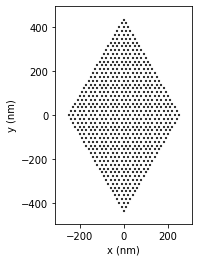

N dipoles: 676


 --- available rasterscan configurations:
index 0: {'kSign': -1, 'spotsize': 200, 'theta': 0, 'wavelength': 750.0}
index 1: {'kSign': -1, 'spotsize': 200, 'theta': 90, 'wavelength': 750.0}


In [3]:
## --- plot the structure
visu.structure(sim.struct.geometry, scale=0.5)
print("N dipoles:", len(sim.struct.geometry))

## --- get a list of all raster-scan map configurations defined in "sim"
rasterscan_fieldconfigs = tools.get_possible_field_params_rasterscan(sim)
print('\n\n --- available rasterscan configurations:')
for i, p in enumerate(rasterscan_fieldconfigs):
    print("index {}: {}".format(i, p))

 - Indices "0" and "1" correspond to two full rasterscans with perpendicular polarizations of the incident field
 
Let's run the simulation:
----------------------------

In [4]:
E = core.scatter(sim)


timing for wl=750.00nm - setup: 264.3 ms, inv.: 450.3 ms, repropa.: 6611.4ms (1250 field configs), tot: 7326.3 ms


Note that *core.scatter* above calculated $2 \times 25 \times 25 = 1250$ simulations!

Calcuate raster-scan maps
---------------------------
Now comes the part where we calculate the raster-scan maps from the 1250 fields inside the nanoparticles (which are all stored in **sim.E**):

In [5]:
## raster-scan indices 0,1: 0,90 deg

## --- TPL
print("calculating TPL...")
TPL0 = tools.calculate_rasterscan(sim, 0, nonlinear.tpl_ldos)
TPL90 = tools.calculate_rasterscan(sim, 1, nonlinear.tpl_ldos)


## --- heat
print("calculating heat...")
Q0 = tools.calculate_rasterscan(sim, 0, linear.heat, return_units='uW')
Q90 = tools.calculate_rasterscan(sim, 1, linear.heat, return_units='uW')


## --- temperature increase
print("calculating temperature rise at (0,0,150)...")
r_probe = (0, 0, 150)
DT0 = tools.calculate_rasterscan(sim, 0, linear.temperature, r_probe=r_probe, kappa_env=0.6)
DT90 = tools.calculate_rasterscan(sim, 1, linear.temperature, r_probe=r_probe, kappa_env=0.6)

calculating TPL...
calculating heat...
calculating temperature rise at (0,0,150)...


**Note:** You should be sure to have chosen the correct indices (0 or 1 in our example) for the  raster-scan simulations. That's why we checked the indices above.


Plotting the maps
-------------------
Now we have calculated 2D scalar maps of different physical quantities as function of a focused beam's position on the structure. 
We need to do nothing more that plotting it:

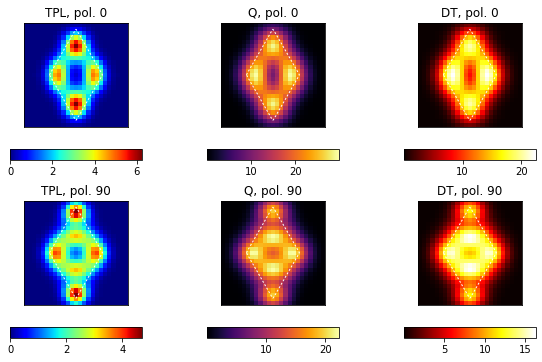

In [7]:
plt.figure(figsize=(10,6))

## --- limit the number of ticks on the axes (for the colorbar!)
from matplotlib.ticker import MaxNLocator
MaxNLocator.default_params['nbins'] = 4


## --- TPL
plt.subplot(2,3,1, aspect='equal')
plt.xticks([]); plt.yticks([]); plt.title("TPL, pol. 0")
im = visu.scalarfield(TPL0, cmap='jet', show=False)
plt.colorbar(im, orientation='horizontal', shrink=0.8, aspect=12)
visu.structure_contour(geometry, color='w', dashes=[2,2], lw=1.0, input_mesh='hex_onelayer', show=0)

plt.subplot(2,3,4, aspect='equal')
plt.xticks([]); plt.yticks([]); plt.title("TPL, pol. 90")
im = visu.scalarfield(TPL90, cmap='jet', show=False)
plt.colorbar(im, orientation='horizontal', shrink=0.8, aspect=12)
visu.structure_contour(geometry, color='w', dashes=[2,2], lw=1.0, input_mesh='hex_onelayer', show=0)


## --- heat
plt.subplot(2,3,2, aspect='equal')
plt.xticks([]); plt.yticks([]); plt.title("Q, pol. 0")
im = visu.scalarfield(Q0, cmap='inferno', show=False)
plt.colorbar(im, orientation='horizontal', shrink=0.8, aspect=12)
visu.structure_contour(geometry, color='w', dashes=[2,2], lw=1.0, input_mesh='hex_onelayer', show=0)

plt.subplot(2,3,5, aspect='equal')
plt.xticks([]); plt.yticks([]); plt.title("Q, pol. 90")
im = visu.scalarfield(Q90, cmap='inferno', show=False)
plt.colorbar(im, orientation='horizontal', shrink=0.8, aspect=12)
visu.structure_contour(geometry, color='w', dashes=[2,2], lw=1.0, input_mesh='hex_onelayer', show=0)


## --- temperature rise
plt.subplot(2,3,3, aspect='equal')
plt.xticks([]); plt.yticks([]); plt.title("DT, pol. 0")
im = visu.scalarfield(DT0, cmap='hot', show=False)
plt.colorbar(im, orientation='horizontal', shrink=0.8, aspect=12)
visu.structure_contour(geometry, color='w', dashes=[2,2], lw=1.0, input_mesh='hex_onelayer', show=0)

plt.subplot(2,3,6, aspect='equal')
plt.xticks([]); plt.yticks([]); plt.title("DT, pol. 90")
im = visu.scalarfield(DT90, cmap='hot', show=False)
plt.colorbar(im, orientation='horizontal', shrink=0.8, aspect=12)
visu.structure_contour(geometry, color='w', dashes=[2,2], lw=1.0, input_mesh='hex_onelayer', show=0)


plt.show()